In [114]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
import momepy as mm

regions_datadir = "/data/uscuni-ulce/"
data_dir = "/data/uscuni-ulce/processed_data/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")
graph_dir = data_dir + "neigh_graphs/"
chars_dir = "/data/uscuni-ulce/processed_data/chars/"

In [115]:
from core.cluster_validation import generate_enc_groups
from core.utils import used_keys

In [116]:
query = "living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link|unclassified"
approved_roads = query.split('|')

In [117]:
region_id = 69300

In [118]:
osm_streets = gpd.read_parquet(data_dir + f"streets/streets_{region_id}.parquet")

In [119]:
prague_streets = gpd.read_file('../../notebooks/data/prg_geometry.gpkg', layer='edges')
prague_streets = prague_streets.to_crs(osm_streets.crs)

In [120]:
overture_streets = gpd.read_parquet('../data/prague_overture_segment.geoparquet')
# overture_streets = overture_streets[overture_streets['subtype'] == 'road']
overture_streets = overture_streets[overture_streets['class'].isin(approved_roads)]
overture_streets = overture_streets.to_crs(osm_streets.crs)
overture_streets['class'].unique()

array(['tertiary', 'residential', 'living_street', 'secondary',
       'unclassified', 'motorway', 'trunk', 'primary', 'pedestrian'],
      dtype=object)

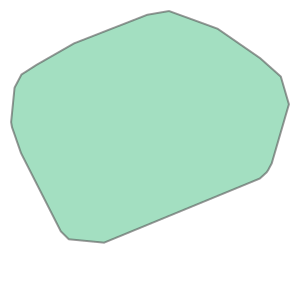

In [11]:
prague_boundary = prague_streets.buffer(100, resolution=2).union_all().convex_hull
prague_boundary

In [12]:
osm_streets = osm_streets[prague_boundary.contains(osm_streets.geometry)]
osm_streets.shape

(57753, 2)

In [13]:
overture_streets = overture_streets[prague_boundary.contains(overture_streets.geometry)]
overture_streets.shape

(35045, 18)

In [14]:
osm_streets = osm_streets.sort_values('geometry').reset_index(drop=True)
prague_streets = prague_streets.sort_values('geometry').reset_index(drop=True)
overture_streets = overture_streets.sort_values('geometry').reset_index(drop=True)

<Axes: >

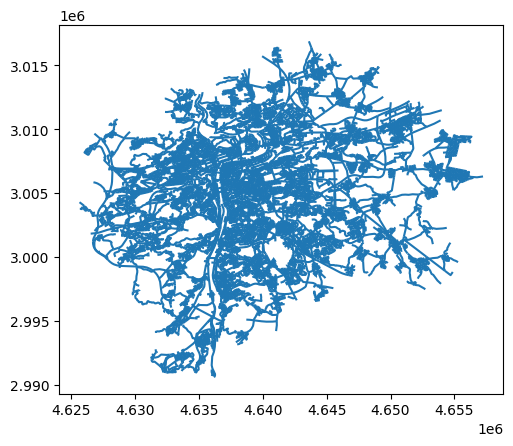

In [15]:
prague_streets.plot()

<Axes: >

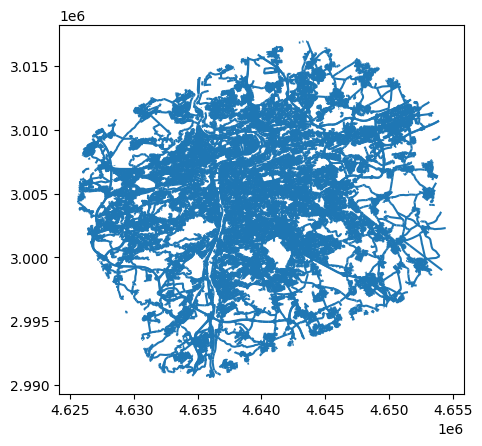

In [16]:
osm_streets.plot()

<Axes: >

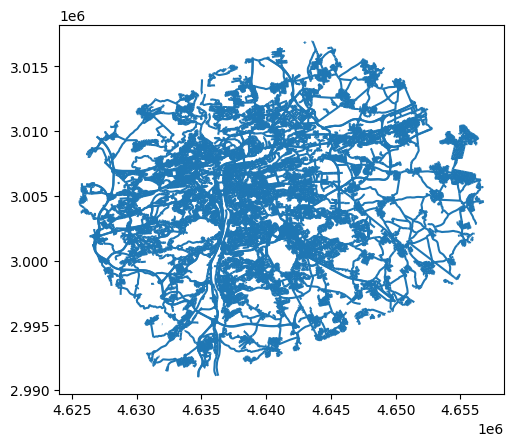

In [17]:
overture_streets.plot()

In [18]:
prague_streets.length.describe().loc[['count', 'mean', '25%', '50%', '75%', 'max']]

count    22503.000000
mean       143.278878
25%         65.078251
50%        100.824936
75%        162.969783
max       3328.299016
dtype: float64

In [19]:
osm_streets.length.describe().loc[['count', 'mean', '25%', '50%', '75%', 'max']]

count    57753.000000
mean        99.588944
25%         26.083373
50%         59.982828
75%        123.950930
max       3785.095999
dtype: float64

In [20]:
overture_streets.length.describe().loc[['count', 'mean', '25%', '50%', '75%', 'max']]

count    35045.000000
mean       117.663986
25%         41.941917
50%         80.785613
75%        138.169426
max       4638.937476
dtype: float64

In [21]:
import lonboard

In [24]:
# osm_layer = lonboard.PathLayer.from_geopandas(osm_streets, width_min_pixels=1, get_color=[255, 0, 0])
# overture_layer = lonboard.PathLayer.from_geopandas(overture_streets, width_min_pixels=1)
# prague_layer = lonboard.PathLayer.from_geopandas(prague_streets, width_min_pixels=1, get_color=[0, 255, 0])

# m = lonboard.Map([osm_layer, overture_layer, prague_layer])
# m

In [165]:
# from mapclassify import greedy

In [166]:
# osm_streets.plot(
#     greedy(osm_streets), categorical=True, figsize=(10, 10), cmap="Set3"
# ).set_axis_off()

In [167]:
# %%time
# res = mm.remove_false_nodes(osm_streets)
# res

In [168]:
# osm_layer = lonboard.PathLayer.from_geopandas(osm_streets, width_min_pixels=1, get_color=[255, 0, 0])
# osm_layer2 = lonboard.PathLayer.from_geopandas(res, width_min_pixels=1)

# m = lonboard.Map([osm_layer, osm_layer2])
# m

In [169]:
# %%time
# res = mm.extend_lines(res, tolerance=0.2)
# res

In [170]:
# %%time
# res = mm.close_gaps(res, 0.25)
# res

In [171]:
# osm_streets.length.describe()

In [172]:
# res.length.describe()

In [86]:
new_gdf = mm.remove_false_nodes(overture_streets)
new_gdf.shape

(33896, 18)

In [87]:
nx_graph = mm.gdf_to_nx(new_gdf)
nx_graph = mm.node_degree(nx_graph)

In [88]:
nodes_gdf, edges_gdf = mm.nx_to_gdf(nx_graph)
edges_gdf.shape

(33896, 21)

In [89]:
# nodes_gdf[nodes_gdf['degree'] == 2].explore()

In [109]:
old_shape = overture_streets.shape
new_gdf = mm.remove_false_nodes(overture_streets)
new_shape = new_gdf.shape
while old_shape != new_shape:
    new_gdf = mm.remove_false_nodes(new_gdf)
    old_shape = new_shape
    new_shape = new_gdf.shape

In [110]:
nx_graph = mm.gdf_to_nx(new_gdf)
nx_graph = mm.node_degree(nx_graph)
nodes_gdf, edges_gdf = mm.nx_to_gdf(nx_graph)


In [99]:

streets = new_gdf

streets['length'] = streets.length
streets['osmid'] = streets.index.values
streets.shape

(33910, 20)

In [100]:
nx_graph = mm.gdf_to_nx(streets[['length', 'geometry', 'osmid']], integer_labels=True)

In [54]:
# !pip install osmnx

In [101]:
import osmnx as ox

In [102]:
nx_graph = ox.get_undirected(nx_graph)

/tmp/ipykernel_1910612/3750956869.py:1: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  nx_graph = ox.get_undirected(nx_graph)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/osmnx/convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


In [103]:
consolidated_graph = mm.consolidate_intersections(
    nx_graph
)

In [104]:
edges_gdf = mm.nx_to_gdf(consolidated_graph, points=False, lines=True)
edges_gdf.shape

(27999, 9)

In [105]:
new_gdf = edges_gdf['geometry']
new_gdf.loc[new_gdf.isna()] = edges_gdf.loc[new_gdf.isna(), 'new_geometry']
new_gdf = new_gdf.to_frame()

<Axes: >

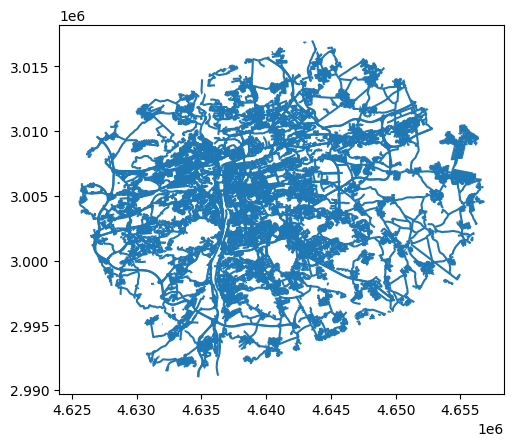

In [106]:
new_gdf.plot()

In [113]:
# overture_layer = lonboard.PathLayer.from_geopandas(overture_streets, width_min_pixels=1, get_color=[255, 0, 0])
# processed_layer = lonboard.PathLayer.from_geopandas(edges_gdf, width_min_pixels=1)

# m = lonboard.Map([overture_layer, processed_layer])
# m

In [146]:
consolidated_graph = mm.consolidate_intersections(
    nx_graph, tolerance=30, rebuild_graph=False
)

In [147]:
from momepy.preprocessing import _get_rebuilt_edges

In [148]:
consolidated_graph.graph["approach"] = "primal"
_, edges_gdf = mm.nx_to_gdf(nx_graph)

In [149]:
# Collect nodes and their data:

def helper(graph, tolerance, x_att='x', y_att='y'):
    from copy import deepcopy
    import networkx as nx
    nodes, nodes_dict = zip(*graph.nodes(data=True), strict=False)
    nodes_df = pd.DataFrame(nodes_dict, index=nodes)
    graph_crs = graph.graph.get("crs")
    
    # Create a graph without the edges above a certain length and clean it
    #  from isolated nodes (the unsimplifiable nodes):
    components_graph = deepcopy(graph)
    components_graph.remove_edges_from(
        [
            edge
            for edge in graph.edges(keys=True, data=True)
            if edge[-1]["length"] > tolerance
        ]
    )
    isolated_nodes_list = list(nx.isolates(components_graph))
    components_graph.remove_nodes_from(isolated_nodes_list)
    
    # The connected components of this graph are node clusters we must individually
    #  simplify. We collect them in a dataframe and retrieve node properties (x, y
    #  coords mainly) from the original graph.
    components = nx.connected_components(components_graph)
    components_dict = dict(enumerate(components, start=max(nodes) + 1))
    nodes_to_merge_dict = {
        node: cpt for cpt, nodes in components_dict.items() for node in nodes
    }
    new_nodes_df = pd.DataFrame.from_dict(
        nodes_to_merge_dict, orient="index", columns=["cluster"]
    )
    nodes_to_merge_df = pd.concat(
        [new_nodes_df, nodes_df[[x_att, y_att]]], axis=1, join="inner"
    )
    
    # The two node attributes we need for the clusters are the position of the cluster
    #  centroids. Those are obtained by averaging the x and y columns. We also add
    # . attribtues referring to the original node ids in every cluster:
    cluster_centroids_df = nodes_to_merge_df.groupby("cluster").mean()
    cluster_centroids_df["simplified"] = True
    cluster_centroids_df["original_node_ids"] = cluster_centroids_df.index.map(
        components_dict
    )
    cluster_geometries = gpd.points_from_xy(
        cluster_centroids_df[x_att], cluster_centroids_df[y_att]
    )
    cluster_gdf = gpd.GeoDataFrame(
        cluster_centroids_df, crs=graph_crs, geometry=cluster_geometries
    )
    cluster_nodes_list = list(cluster_gdf.to_dict("index").items())
    return nodes_to_merge_dict, cluster_gdf

In [150]:
nodes_to_merge_dict, cluster_gdf = helper(nx_graph, tolerance=30)

In [151]:

simplified_edges = _get_rebuilt_edges(
    edges_gdf,
    nodes_to_merge_dict,
    cluster_gdf,
    method='spider',
    buffer=1.5 * 30,
    edge_from_att='node_start',
    edge_to_att='node_end',
)

IndexError: index out of range

In [152]:
_ = consolidated_graph.add_edges_from(simplified_edges)

In [153]:
_, edges_gdf = mm.nx_to_gdf(consolidated_graph)

In [154]:
new_gdf = edges_gdf['geometry']
new_gdf.loc[new_gdf.isna()] = edges_gdf.loc[new_gdf.isna(), 'new_geometry']

<Axes: >

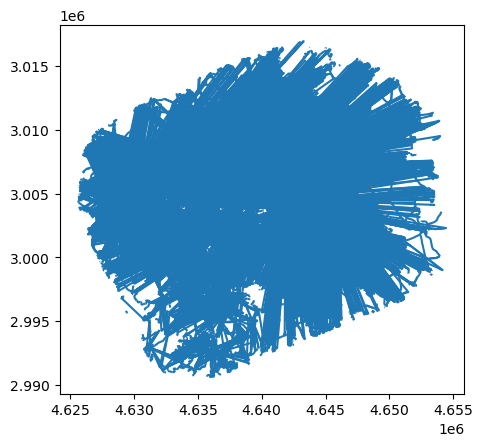

In [155]:
new_gdf.plot()

In [80]:
nodes, nodes_dict = zip(*nx_graph.nodes(data=True), strict=False)
nodes_df = pd.DataFrame(nodes_dict, index=nodes)
graph_crs = nx_graph.graph.get("crs")

In [85]:
edges_gdf = mm.nx_to_gdf(nx_graph, points=False, lines=True)

In [97]:
n, e = mm.nx_to_gdf(nx_graph)

In [98]:
e

,length,geometry,mm_len,node_start,node_end
0,551.865661,"LINESTRING (4628775.382 2997363.561, 4628794.7...",551.865661,0,1
1,576.706025,"LINESTRING (4628819.997 2997936.408, 4628815.6...",576.706025,0,13333
2,15.198367,"LINESTRING (4628962.024 2996855.78, 4628973.39...",15.198367,1,8
3,162.167971,"LINESTRING (4629064.211 2996801.008, 4629077.5...",162.167971,2,3
4,149.504240,"LINESTRING (4629146.861 2997007.469, 4629145.6...",149.504240,4,5
...,...,...,...,...,...
57748,118.351422,"LINESTRING (4650980.347 2996785.931, 4650946.5...",118.351422,70336,70342
57749,124.679863,"LINESTRING (4650906.196 2996693.914, 4650915.9...",124.679863,70336,70343
57750,27.040000,"LINESTRING (4650837.426 2996749.307, 4650841.9...",27.040000,70338,70339
57751,65.895481,"LINESTRING (4650924.438 2996581.296, 4650890.8...",65.895481,70344,70345


In [56]:

# nx_graph = mm.node_degree(nx_graph)

In [57]:
# _, _, w = mm.nx_to_gdf(nx_graph, spatial_weights=True)